# Example of simulation-based model inference (SBMI)
Simultaneous identification of models and parameters of scientific simulators. 
Schöder and Macke. ICML 2024.
https://arxiv.org/abs/2305.15174

In this notebook we focus on the model inference part. Therefore we only sample from a simple model prior, the graph implementation for the model prior is presented in a later notebook.

We will need GrassmannDistribution, clone it and install it from here:
https://github.com/mackelab/grassmann_binary_distribution/tree/main


### Define model and prior

Similar to the paper we will use an "additive" model: we want to learn a one dimensional function $f(t)$ which can consist of different components, namely:
- linear component: $\theta_1^{1} t$
- quadratic component: $\theta_1^3 t^2$
- sinusoidal component: $\theta_1^4 \sin(\theta_2^4 t)$
- noise component: $n_{t_i} \sim \mathcal{N}(0, \theta_1^5)$
- *optional*: linear component:  $\theta_1^{2} t$


This results in five model components with in total five (six) parameters, and a partition of the parameter space in $[1,1,2,1,(1)]$.

The presence/absence of the model components are indicated by a binary vector $M$. 

For simplicity we assume a flat model prior over the component one to three and we assume that the noise term is always present. 

We further assume uniform priors for all parameters $\theta_i^j$. 

In [63]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np  
from sbi.utils import get_parameter_mask
from sbi.utils.sbmi_utils import (SBMISamplingObject, 
                                  evaluate_model_performance)
from sbi.neural_nets import CNNEmbeddingMasked, FCEmbeddingMasked

from grassmann_distribution.conditional_grassmann import (
    GrassmannConditional,
    hidden_fc_net,
)
from sbi.neural_nets import posterior_nn
from sbi import analysis as analysis


from sbi.inference import NPE_SBMI

from sbi.neural_nets.density_estimators.categorical_net_SBMI import CategoricalNet

import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
n_components = 4

if n_components == 4:
    partition = torch.tensor([1, 1, 2, 1])  # partition of the parameters
elif n_components == 5:
    partition = torch.tensor([1, 1, 2, 1, 1])  # partition of the parameters

n_params = partition.sum()

prior_bounds = torch.ones((2, partition.sum()))
# for l1
prior_bounds[0, 0] = 1  # lower bound
prior_bounds[1, 0] = 10  # upper bound
# for quadratic
prior_bounds[0, 1] = 0.5
prior_bounds[1, 1] = 1
# for sine
prior_bounds[0, 2] = 5
prior_bounds[1, 2] = 10
prior_bounds[0, 3] = 1.0
prior_bounds[1, 3] = 5.0
# for noise
prior_bounds[0, 4] = 0.5
prior_bounds[1, 4] = 2

# for l2
if n_components == 5:
    prior_bounds[0, 4] = 2
    prior_bounds[1, 4] = 10


def sample_model_components(n, n_components):
    # the last component is always 1
    m = torch.bernoulli(torch.ones((n, n_components)) * 0.5)
    m[:, -1] = 1
    # make sure at least one component is active:
    # if no component is active, activate the first one
    m[torch.nansum(m, 1) == 1, 0] = 1
    return m


def sample_parameters(m, prior_bounds, partition):
    n, n_components = m.shape
    thetas = torch.rand((n, prior_bounds.shape[1]))
    # scale the thetas to the prior bounds
    thetas = thetas * torch.abs(prior_bounds[1] - prior_bounds[0]) + prior_bounds[0]
    # mask the parameters that are not used
    mask = ~get_parameter_mask(m, partition)
    thetas[mask] = torch.nan
    return thetas


def run_model(m, thetas, n_components):
    n, n_components = m.shape

    thetas = thetas.clone()
    thetas[torch.isnan(thetas)] = 0

    t = torch.arange(0, 10, 0.01)

    # additive model components
    l1 = thetas[:, 0].unsqueeze(1) * t
    q = thetas[:, 1].unsqueeze(1) * t**2
    sin = thetas[:, 2].unsqueeze(1) * torch.sin(thetas[:, 3].unsqueeze(1) * t)

    # noise component
    noise = torch.randn(n, len(t)) * thetas[:, 4].unsqueeze(1)

    if n_components == 5:
        l2 = thetas[:, 5].unsqueeze(1) * t
    else:
        l2 = 0

    out = l1 + q + sin + noise + l2
    return out


# Lets generate some data

t = torch.arange(0, 10, 0.01)

n_train = 5_000
m = sample_model_components(n_train, n_components=n_components)
theta = sample_parameters(m, prior_bounds, partition)
x_raw = run_model(m, theta, n_components)

n_test = 100
m_test = sample_model_components(n_test, n_components=n_components)
theta_test = sample_parameters(m_test, prior_bounds, partition)
x_raw_test = run_model(m_test, theta_test, n_components)

# and bring it to the correct shape for SBMI
x = torch.cat([x_raw, m], dim=1)
x_test = torch.cat([x_raw_test, m_test], dim=1)

We have created the training data $\{M, \theta, x_{raw}\}$ which we will use for training. 
- $M$ has shape (n_samples, n_components)
- $\theta$ has shape (n_samples, sum(partition))
- $x_{raw}$ has shape (n, number of timepoints)

The SBMI method assumes for training that the model vector is appended to $x_{raw}$:
$x = [x_{raw},m]$

So we are left with the training data $\{\theta, M \}$

Let's have a look at the data:

 thetas: 0 tensor([7.9582, 0.8490, 7.7039, 3.7068, 0.8660])
 thetas: 1 tensor([2.8628, 0.9645,    nan,    nan, 1.1560])
 thetas: 2 tensor([6.4279,    nan,    nan,    nan, 0.8404])
 thetas: 3 tensor([8.2220,    nan, 5.0160, 3.5736, 0.8884])
 thetas: 4 tensor([   nan, 0.6426, 7.9729, 2.1730, 0.5168])
 thetas: 5 tensor([6.4199, 0.9399, 5.1230, 3.7241, 0.9618])
 thetas: 6 tensor([   nan,    nan, 8.8894, 1.2873, 0.6895])
 thetas: 7 tensor([9.9334, 0.9084, 9.1632, 1.5119, 1.5556])
 thetas: 8 tensor([   nan,    nan, 8.9073, 2.1683, 1.7222])
 thetas: 9 tensor([   nan, 0.5511,    nan,    nan, 1.8518])


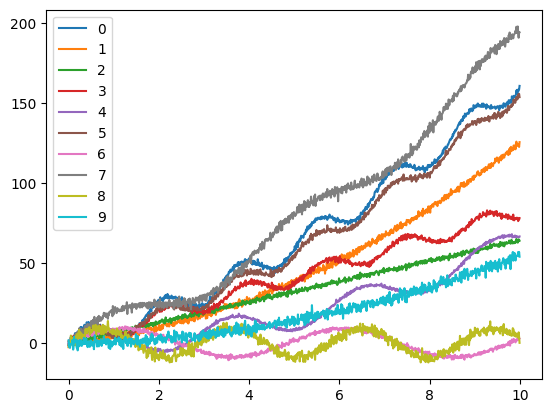

In [3]:
for i in range(10):
    plt.plot(t, x[i, :-n_components].numpy(), label=i)
    print(f" thetas:", i, theta[i])
plt.legend()

plt.show()

In [4]:
print("model components:")
print(x[:5, -n_components:])

model components:
tensor([[1., 1., 1., 1.],
        [1., 1., 0., 1.],
        [1., 0., 0., 1.],
        [1., 0., 1., 1.],
        [0., 1., 1., 1.]])


In [5]:
# quick check for the parameters
for i in range(partition.sum()):
    print("min, max, mean of parameter", i, ":")
    print(
        theta[~torch.isnan(theta[:, i]), i].min(),
        theta[~torch.isnan(theta[:, i]), i].max(),
        torch.nanmean(theta[:, i]),
    )

min, max, mean of parameter 0 :
tensor(1.0002) tensor(9.9979) tensor(5.4798)
min, max, mean of parameter 1 :
tensor(0.5009) tensor(0.9998) tensor(0.7487)
min, max, mean of parameter 2 :
tensor(5.0014) tensor(9.9942) tensor(7.5034)
min, max, mean of parameter 3 :
tensor(1.0011) tensor(4.9962) tensor(2.9668)
min, max, mean of parameter 4 :
tensor(0.5002) tensor(2.0000) tensor(1.2488)


In [6]:
# quick check for the model components
print("mean of model components:", x[:, -n_components:].mean(0))

mean of model components: tensor([0.6218, 0.4890, 0.5016, 1.0000])


### Embedding net


For this time series example we will use a CNN as embedding net. 
As we only want to embed $x_raw$ ($x$ without the model vector) we will use an embedding net which leaves the last dimensions unchanged. 
This is implemented for a CNN, a fully connected net, and obviously `nn.Identity()` can be used if no emedding net is wanted. 

In [56]:
# CNN embedding
x_dim = x.shape[1]
embedding_dim = 50

embedding_net = CNNEmbeddingMasked(
    input_dim=x_dim,  # x_dim is the dimension of the data + the number of model components
    output_dim=embedding_dim,  # this is the effective output dimension, but the last n_components dimensions code the model components
    unchanged_dim=n_components,
    num_fc=3,
    num_hiddens=50,  # hidden dims of the fc layers
)

In [68]:
# Fully connected net
x_dim = x.shape[1]
embedding_dim = 50

embedding_net = FCEmbeddingMasked(
    input_dim=x_dim,
    output_dim=embedding_dim,
    unchanged_dim=n_components,
    num_layers=4,
    num_hiddens=50,
)

In [9]:
# identity network
x_dim = x.shape[1]
embedding_dim = x_dim
embedding_net = torch.nn.Identity()

### The model posterior network (MPN)


We can choose between two different model posterior networks: a grassmann network or a categorical network. 

In [69]:
model_posterior_type = "grassmann"  # "categorical" or "grassmann"
# Warning:
# GrassmannConditional is returning probs
# CategoricalNet is returning logprobs

if model_posterior_type == "grassmann":
    model_net_prob = "prob"
    h = hidden_fc_net(
        input_dim=embedding_dim - n_components,
        output_dim=30,
        num_fc_layers=3,
        num_hiddens=50,  # number of layers
    )  # hidden dimension (should be large enough...)

    model_net = GrassmannConditional(
        features=n_components,  # dim
        hidden_features=30,  # output dim of hidden net
        hidden_net=h,
        num_components=3,  # number of components for the MoGrassmann
    )

elif model_posterior_type == "categorical":
    model_net_prob = "log_prob"
    model_net = CategoricalNet(
        num_input=embedding_dim - n_components,
        num_categories=2**n_components,
        num_hidden=50,
        num_layers=3,
        binary_vector_input=True,
    )

In [70]:
# test the untrained model
x_emb = embedding_net(x[:10])
probs = model_net(x_emb[:, -n_components:], x_emb[:, :-n_components])
print(probs)

tensor([0.1066, 0.1190, 0.0603, 0.0483, 0.0885, 0.1057, 0.0440, 0.1078, 0.0449,
        0.1183], grad_fn=<SumBackward1>)


### The parameter posterior network
As we SBMI is based on marginalization during training time, we use a Gaussian MDN network with all the necessary functionality. 

In [71]:
density_estimator_build_fun = posterior_nn(
    model="mdn_flex",
    partition=partition,
    hidden_features=embedding_dim,
    num_components=3,
    z_score_x=None,  # None
    z_score_theta=None,  #'independent'
    embedding_net=embedding_net,
)

With this setup we can use the `SBI` framework: 

In [72]:
inference = NPE_SBMI(
    model_net=model_net,
    partition=partition,
    density_estimator=density_estimator_build_fun,
    loss_kwargs={"model_net": model_net_prob},
)

### Training

In [73]:
# append the simulations to the inference object
inference = inference.append_simulations(theta, x)

# set seed
torch.manual_seed(2023)

# train the inference model
density_estimator = inference.train(
    max_num_epochs=100,
    training_batch_size=1000,
    learning_rate=5e-3,
    force_first_round_loss=True,
    model_loss_weight=1,
    validation_fraction=0.1,  # fraction of data used for validation. Default=0.1
    stop_after_epochs=10,  # number of epochs to wait before training is stopped. Default=20
)

 Neural network successfully converged after 60 epochs.

Let's have a quick look what the loss curves look like:

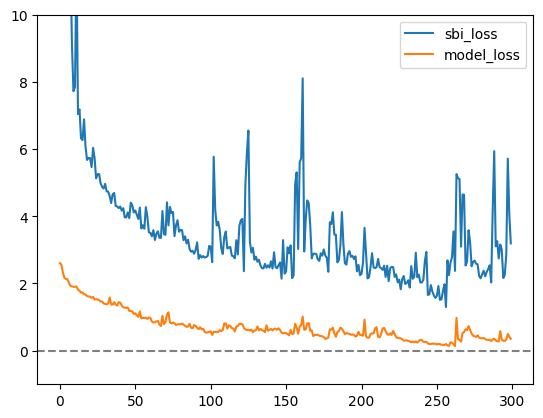

In [74]:
plt.plot(inference.summary["sbi_loss"], label="sbi_loss")
plt.plot(inference.summary["model_loss"], label="model_loss")
plt.ylim(-1, 10)
plt.axhline(0, color="grey", linestyle="--")
plt.legend()

Text(0.5, 0, 'epoch')

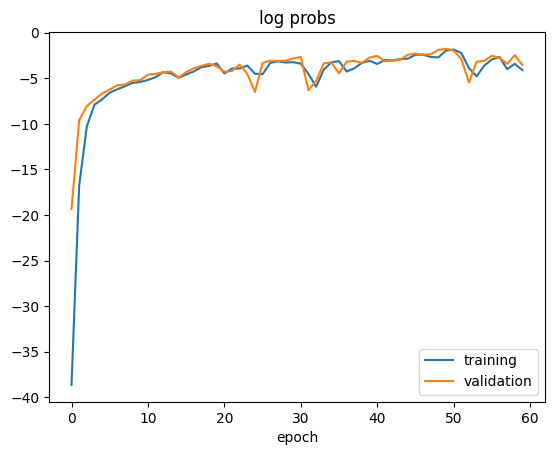

In [76]:
plt.title("log probs")
plt.plot(np.array(inference.summary["training_log_probs"]), label="training")
plt.plot(np.array(inference.summary["validation_log_probs"]), label="validation")
plt.legend()
plt.xlabel("epoch")

In [77]:
sbi_posterior = inference.build_posterior()

In [17]:
# For saving the posterior and model net

# dict_to_save = {
#     "summary": inference.summary,
#     "sbi_posterior": sbi_posterior,
#     "model_net": inference._model_net,
# }

# with open("inference.pkl", "wb") as f:
#     pickle.dump(dict_to_save, f)
# print("model saved.")

### Evaluating the posterior

### Sampling from the model posterior:



In [78]:
# create a sampler object
sampler = SBMISamplingObject(
    sbi_posterior,
    model_posterior=model_net,
    embedding_net=sbi_posterior.posterior_estimator.net._embedding_net,
    partition=partition,
    model_posterior_type=model_posterior_type,
)

In [79]:
# sample models given context x[i]
i = 0
print(x_test[i, -n_components:])
ms = sampler.sample_model(500, x_test[i, :-n_components])
print(ms.mean(0))

# there is already a method for this
mean_ms = sampler.model_sample_mean(500, x_test[i, :-n_components])
print(mean_ms)

tensor([0., 1., 0., 1.])
tensor([0.0500, 0.9860, 0.0380, 0.9860])
tensor([0.0500, 0.9900, 0.0240, 0.9880])


In [80]:
# we can also directly compute the "performance" compared to the true models
test_all, _ = evaluate_model_performance(x_test, sampler, n_components, n_samples=100)

print(test_all.mean(0))

tensor([0.9215, 0.9602, 0.8949, 0.9930])


### Sampling from the parameter posterior
For this we need always condition on a sampled model.

In [81]:
i = 1
# we can either take the true model mask
model_mask = x_test[i, -n_components:]
print("ground truth model mask:", model_mask)
# or the predicted one
model_mask_predicted = sampler.sample_model(1, x_test[i, :-n_components]).squeeze()
print("predicted model mask:", model_mask_predicted)
theta_samples = sampler.sample_theta(
    1000, x_test[i, :-n_components], model_mask_predicted, verbose=True
)

ground truth model mask: tensor([0., 1., 0., 1.])
predicted model mask: tensor([0., 1., 0., 1.])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [82]:
print("gt thetas:", theta_test[i])
print("mean of sampled thetas:", theta_samples.mean(0))

gt thetas: tensor([   nan, 0.7380,    nan,    nan, 1.5818])
mean of sampled thetas: tensor([0.7521, 1.2277])


/var/folders/kx/9z7xgc9916l5ztl7kgxlydkm0000gn/T/ipykernel_3984/489864711.py:9: DeprecationWarning: **kwargs are deprecated, use fig_kwargs instead. 
               Calling the to be deprecated pairplot function
  fig, ax = analysis.pairplot(


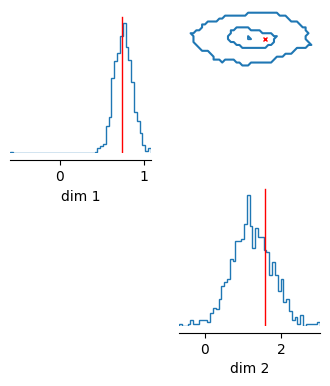

In [83]:
# plot parameter posteriot
# extract the gt points and put into correct dimensions
parameter_mask_sample = get_parameter_mask(
    model_mask_predicted.unsqueeze(0), partition
).squeeze()
points = theta_test[i][parameter_mask_sample]

# plot posterior samples
fig, ax = analysis.pairplot(
    theta_samples,
    # limits=prior_bounds.T.view(-1, 2)[parameter_mask_sample],
    # limits=plotting_limits,
    figsize=(4, 4),
    points=[points],
    points_colors=["red", "green"],
    upper="contour",  # 'scatter' hist, scatter, contour, cond, None
    **{  #'title': f'Paramter prediction given model {model_sample.numpy()}',
        "kde_offdiag": {"bins": 50},
        "points_offdiag": {"markersize": 3, "marker": "x"},
        "contour_offdiag": {"levels": [0.023, 0.5, 0.977]},
        "points_diag": {"ls": "-", "lw": 1, "alpha": 1},
    },
)

In [84]:
# further useful methods
x_i = x_test[i, :-n_components]
theta_i = theta_test[i]
m_i = x_test[i, -n_components:]

# calculate the log likelihood of a given theta
p_theta = sampler.theta_log_prob(x_i, m_i, theta_i)
print(p_theta)

# p model
p_m = sampler.p_model_mask(m_i.unsqueeze(0), x_i)
print(p_m)

tensor([0.8268])
tensor([0.8964])


In [85]:
# MAP estimates for the model
m_map, p_map, m_all, p_m_all = sampler.map_model_mask(x_i, return_all=True)
print("MAP model mask:", m_map)
print("gt model mask:", m_i)
print("MAP prob:", p_map)

MAP model mask: tensor([0., 1., 0., 1.])
gt model mask: tensor([0., 1., 0., 1.])
MAP prob: tensor([0.8964])


In [86]:
# quick and dirty MAP for thetas givent the model m_map
theta_map = sampler.map_dirty(x_i, m_map, runs=10)
print("MAP thetas:", theta_map)
print("gt thetas:", theta_i[~torch.isnan(theta_i)])

MAP thetas: tensor([0.7505, 1.2454], dtype=torch.float64)
gt thetas: tensor([0.7380, 1.5818])
